In [1]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torch.utils.data import DataLoader

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.manifold import TSNE

import seaborn as sns

import random
import ipyplot
from tqdm import tqdm
from livelossplot import PlotLosses

torch.manual_seed(4096)

In [2]:
conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

In [3]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcc.Class, rcp.FileName, rcc.goods_denomination \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
             INNER JOIN text ON (trademark.caseno = text.caseno) \
where ( text.chinese is null and text.english is null and text.japanese is null and text.symbol is null) \
        ") 
r = cur.fetchall()

CPU times: user 122 ms, sys: 13.8 ms, total: 135 ms
Wall time: 775 ms


In [4]:
caseno_list += [i for i in r]
len(caseno_list)

64607

In [5]:
data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'class', 'filename','goods_denomination'])
data['path'] = '/service/trademark/raw_register_data/' + data.doc+ '/' + data.filename
data.dropna(inplace=True)
data.to_csv('img_index.csv', index=False)

In [6]:
data = pd.read_csv('img_index.csv')
data.design.value_counts()

(墨色)(平面)    43617
(彩色)(平面)    19011
(彩色)(立體)     1032
(墨色)(立體)      717
(彩色)(動態)      119
(墨色)(聲音)       16
(彩色)(顏色)       10
(彩色)(其他)        2
(墨色)(其他)        2
Name: design, dtype: int64

In [7]:
# 隨機印出各種圖片
def show_img_design(design, num=4):
    imgs = []
    a = list(data[data.design==design]['path'])
    if len(a) <= num:
        for i in a:
            img = Image.open( i )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    else:
        for i in range(num):
            img = Image.open( random.choice(a) )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    ipyplot.plot_images(imgs, max_images=num)
#     display(imgs)

(墨色)(平面)



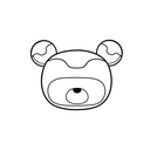
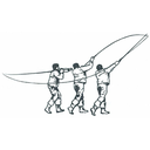
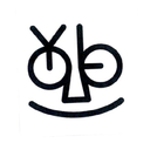
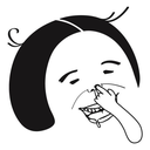
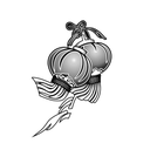
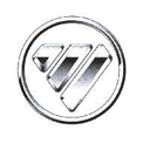
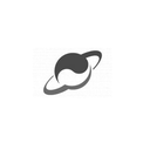
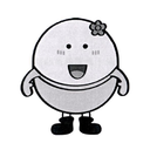
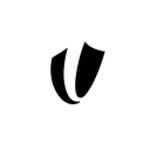
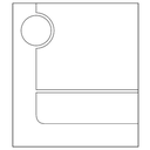
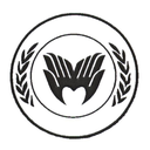
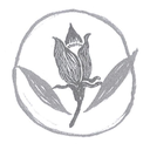
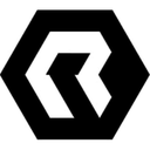
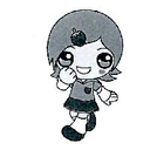
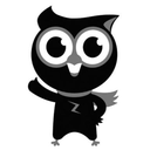


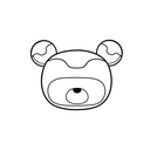
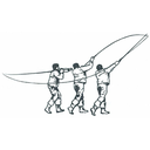
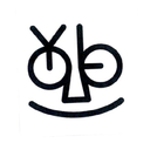
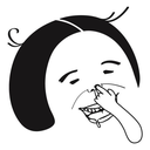
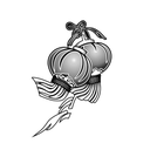
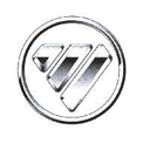
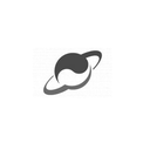
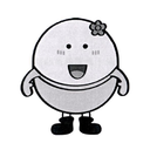
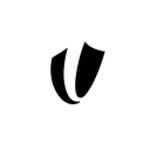
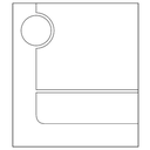
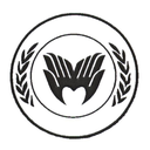
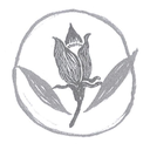
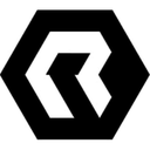
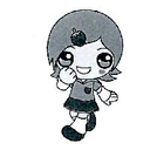
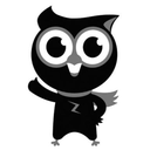

(彩色)(其他)



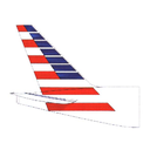
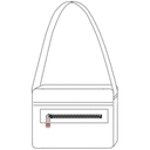


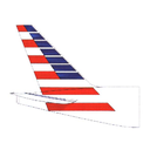
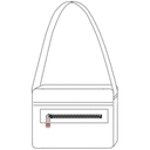

(彩色)(動態)



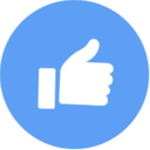
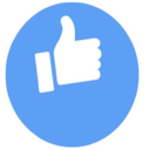
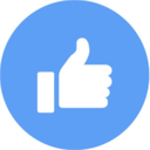
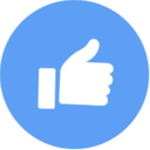
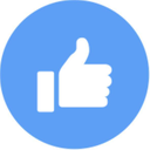
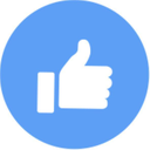
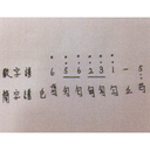
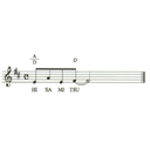
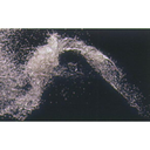
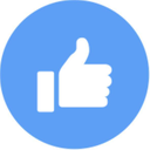
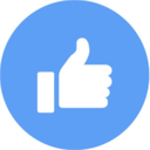
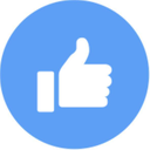
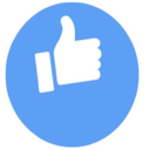
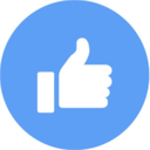
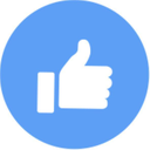


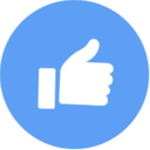
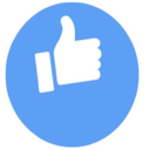
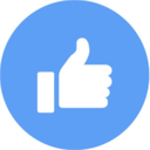
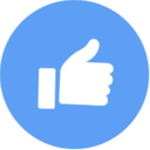
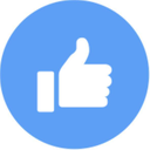
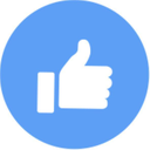
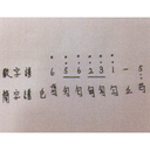
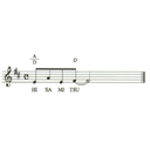
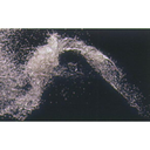
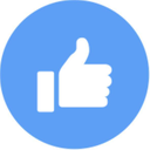
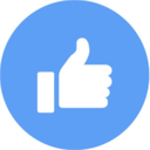
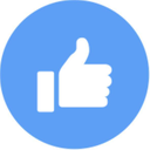
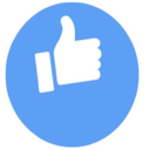
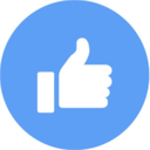
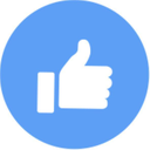

(墨色)(立體)



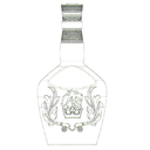
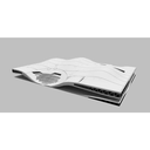
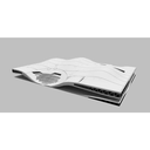
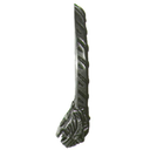
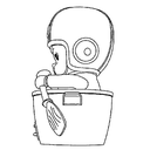
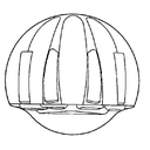
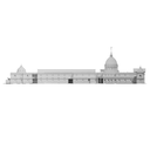
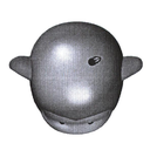
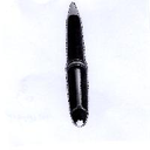
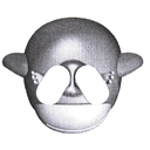
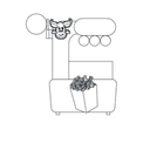
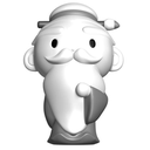
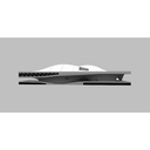
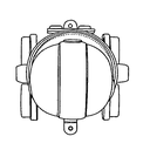
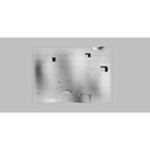


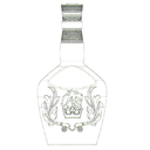
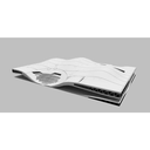
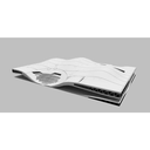
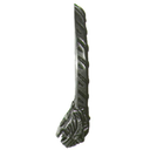
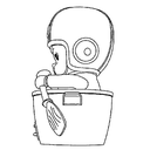
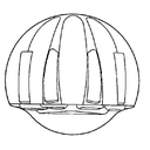
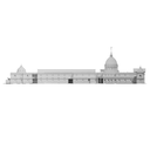
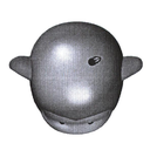
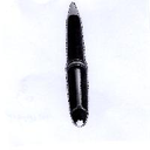
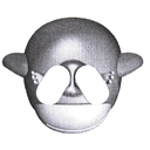
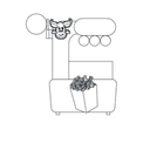
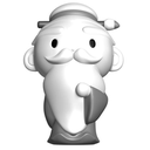
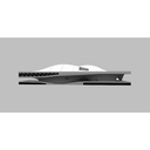
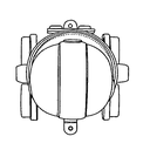
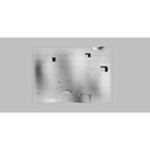

(墨色)(聲音)



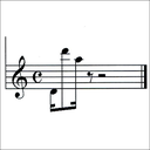
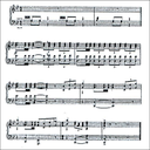
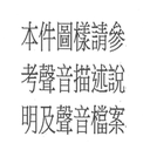
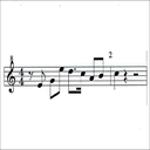
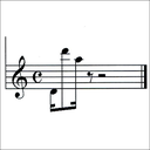
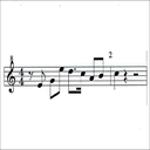
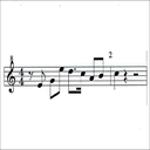
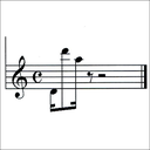
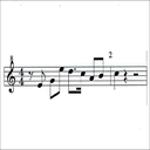
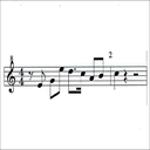
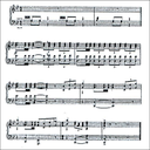
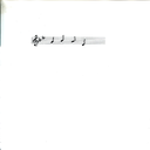
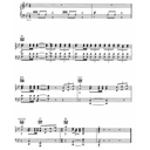
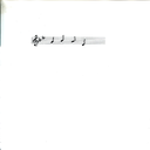
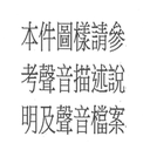


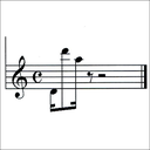
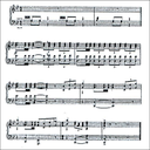
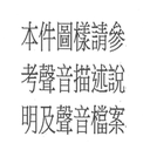
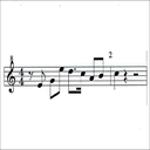
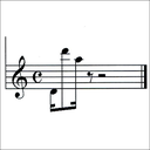
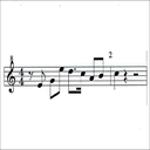
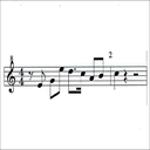
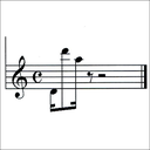
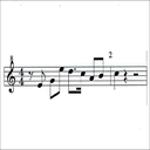
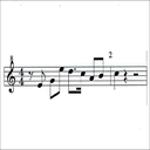
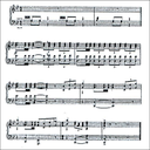
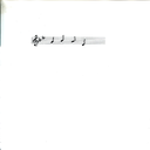
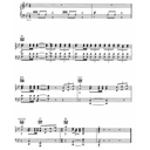
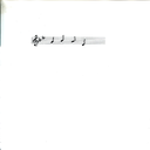
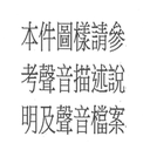

(墨色)(其他)



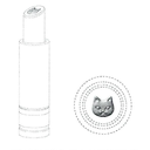
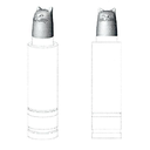


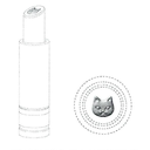
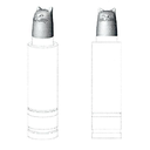

(彩色)(立體)



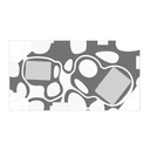
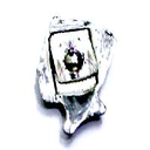
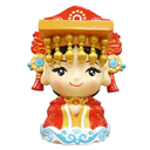
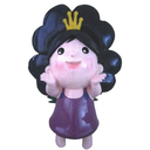
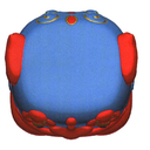
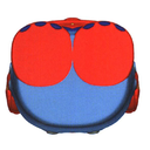
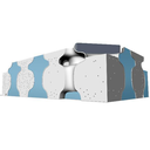
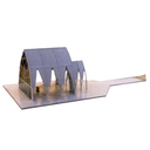
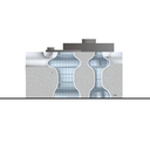
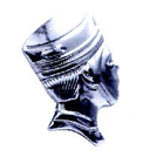
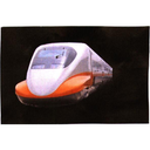
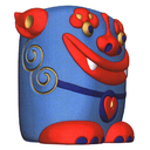
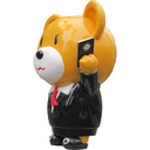
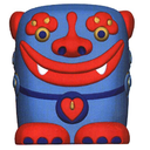
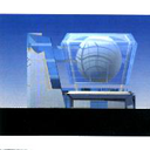


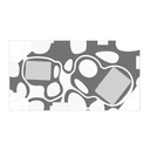
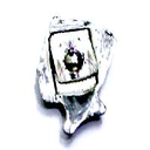
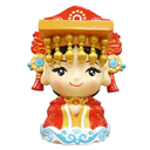
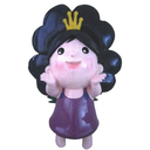
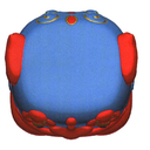
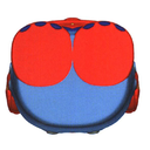
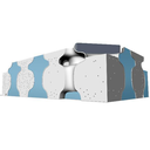
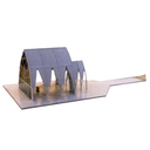
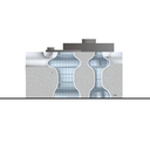
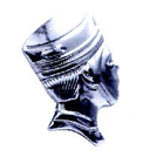
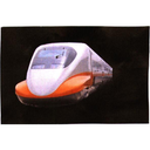
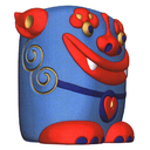
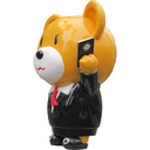
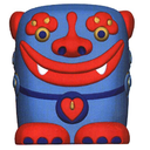
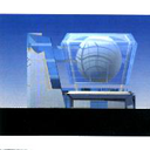

(彩色)(顏色)



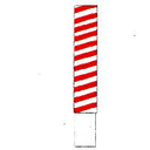
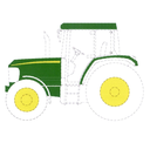
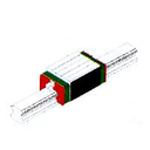
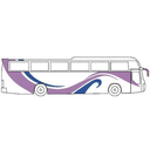
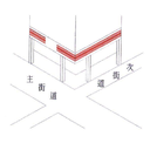
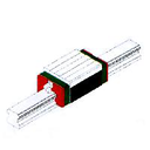
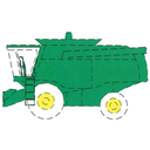
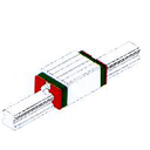
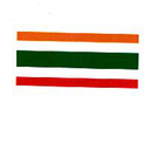
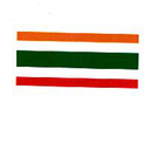


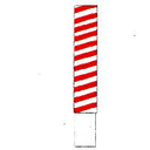
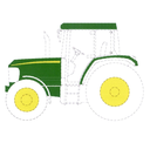
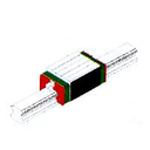
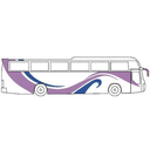
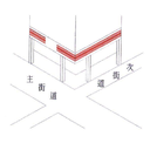
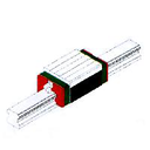
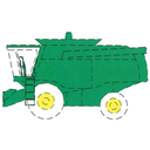
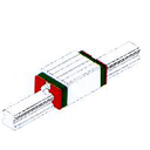
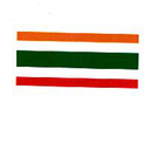
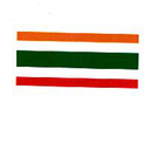

(彩色)(平面)



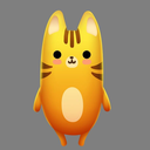
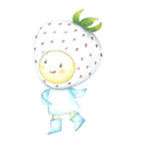
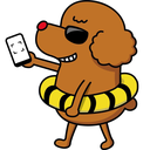
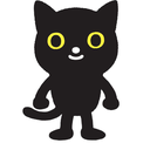
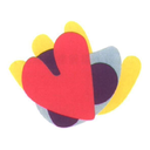
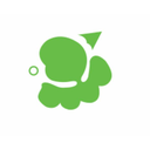
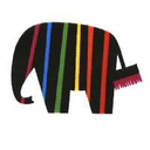
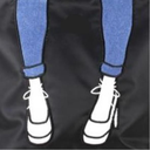
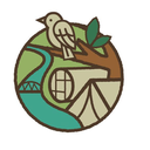
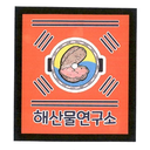
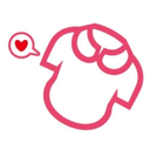
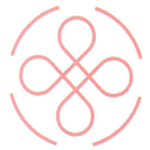
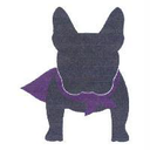
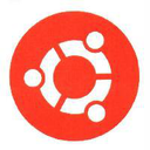
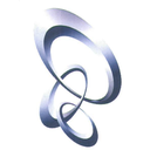


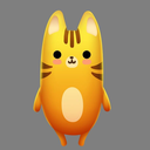
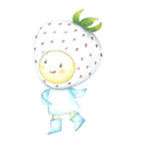
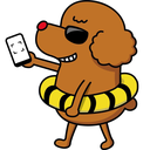
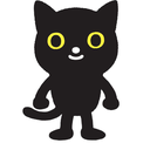
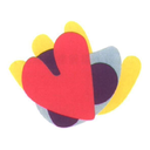
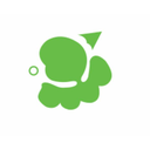
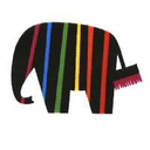
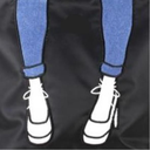
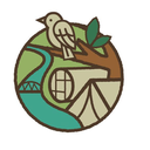
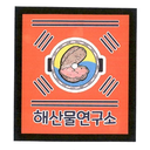
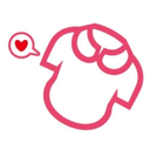
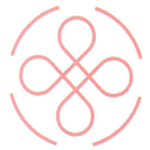
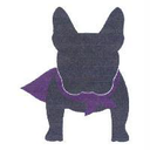
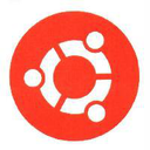
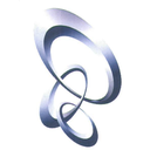

In [8]:
for i in set(data.design):
    print(i)
    show_img_design(i, 15)

In [9]:
# data = data[(data['design'] == '(墨色)(平面)') | ( data['design'] =='(彩色)(平面)' )]
data = data[ data['design'] =='(彩色)(平面)' ]

In [10]:
data.design.value_counts()

(彩色)(平面)    19011
Name: design, dtype: int64

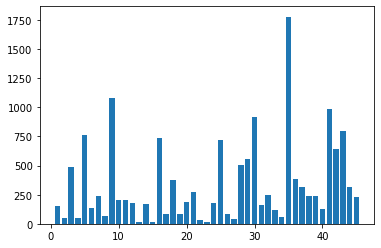

In [11]:
train_ = 0.8
test_ = 0.2
train_data = data[:int(data.shape[0]*train_)]
test_data = data[int(data.shape[0]*train_):]
plt.bar(x=train_data['class'].value_counts().index, height = train_data['class'].value_counts().values)
plt.show()

In [12]:
# %%time
# img_folder = './img'
# os.mkdir(img_folder)
# os.mkdir(img_folder + '/train')
# os.mkdir(img_folder + '/test')

# for i in range(1,46):
#     os.mkdir(img_folder + '/train/'+ str(i))
#     os.mkdir(img_folder + '/test/'+ str(i))

# error = []
# for i, j, k in zip(train_data['filename'], train_data['path'], train_data['class']):
# #     im = Image.open(j)
# #     im.save('./img_representaion/{}/'.format(int(k))  +i.split('/')[1])
# #     display(im)
# #     print(j)
#     try:
#         shutil.copy(j, (img_folder + '/train/{}/').format(int(k))  +i.split('/')[1])
#     except:
#          error.append(j)


# for i, j, k in zip(test_data['filename'], test_data['path'], test_data['class']):
#     try:
#         shutil.copy(j, (img_folder + '/test/{}/').format(int(k))  +i.split('/')[1])
#     except:
#          error.append(j)

In [13]:
error

NameError: name 'error' is not defined

## Load image

In [2]:
train_data = torchvision.datasets.ImageFolder('./img/train',
transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

test_data = torchvision.datasets.ImageFolder('./img/test',
transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)
print(len(train_loader))
print(len(test_loader))

476
3803


In [4]:
# # Data
# transform=transforms.Compose([
# #     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
                                         
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, 45)


model = model.to(device)
# model.eval()
# model.training

# 固定除了最後 12 layer
# lr 調小
# SGD

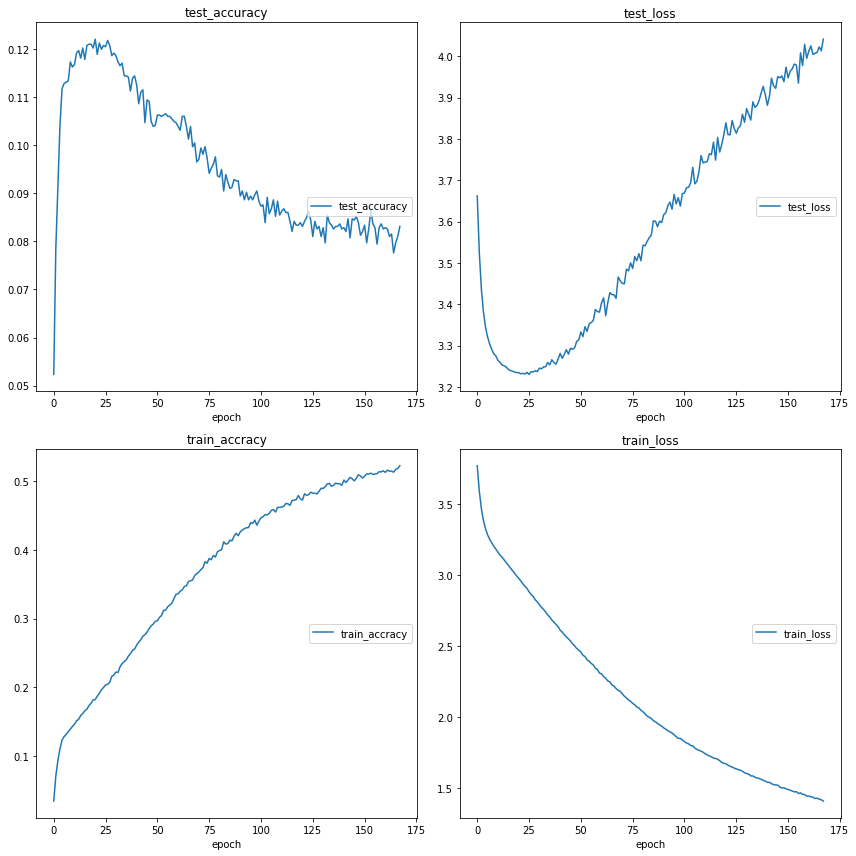

  0%|          | 0/476 [00:00<?, ?it/s]

test_accuracy
	test_accuracy    	 (min:    0.052, max:    0.122, cur:    0.083)
test_loss
	test_loss        	 (min:    3.230, max:    4.041, cur:    4.041)
train_accracy
	train_accracy    	 (min:    0.035, max:    0.522, cur:    0.522)
train_loss
	train_loss       	 (min:    1.409, max:    3.768, cur:    1.409)
epoch : 168


 75%|███████▍  | 355/476 [05:22<01:49,  1.10it/s]


KeyboardInterrupt: 

In [6]:
%%time
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)


num_epochs = 500
liveloss = PlotLosses()

# Train
for epoch in range(num_epochs):
    print("epoch :", epoch)
    logs = {}
    running_loss = 0.0
    correct = 0
    train_accs = []
    test_accs = []
    test_loss = []
    model.train()
    for times, data in enumerate(tqdm(train_loader)):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
        train_accs.append(acc)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        

    logs['train_loss'] = running_loss/times
    logs['train_accracy'] = sum(train_accs) / len(train_accs)
    with torch.no_grad():
        for data in tqdm(test_loader):
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss.append(loss.detach().item())
            acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
            test_accs.append(acc)

    logs['test_loss'] = sum(test_loss) / len(test_loss)
    logs['test_accuracy'] = sum(test_accs) / len(test_accs)
    liveloss.update(logs)
    liveloss.send()
print('Finished Training')

In [ ]:

plt.bar(x=data['class'].value_counts().index, height = data['class'].value_counts().values)
plt.show()

## t-SNE

In [ ]:
plt.style.use('default')

In [ ]:
%%time
tsne_vec_euc = TSNE(n_components=2,  metric='euclidean',n_jobs=-1, perplexity=30).fit_transform(img_vectors)
np.savetxt('./tsne_vec_euc.csv',tsne_vec_euc, delimiter=',')

In [ ]:
tsne_vec_euc = np.genfromtxt('./tsne_vec_euc.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_euc[:,0], Feature_2=tsne_vec_euc[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()

In [ ]:
%%time
tsne_vec_cos = TSNE(n_components=2,  metric='cosine',n_jobs=-1, perplexity=30).fit_transform(img_vectors)
np.savetxt('./tsne_vec_cos.csv',tsne_vec_cos, delimiter=',')

In [ ]:
tsne_vec_cos = np.genfromtxt('./tsne_vec_cos.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_cos[:,0], Feature_2=tsne_vec_cos[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()

第 1 類：工業、科學、照相用，以及農業、園藝、林業用之化學品；未加工人造樹脂、未加工塑膠；
滅火及防火製劑；回火及焊接製劑；為鞣製獸皮及皮革用鞣劑；工業用黏著劑；油灰及其
他糊狀填充劑；堆肥、動物性肥料、化學肥料；工業及科學用生物製劑。
注釋：
本類主要包括工業、科學及農業用化學品，包括製成屬於其他類別產品用的化學品。

第 2 類：漆、清漆、亮光漆；防銹劑及木材防腐劑；著色劑、染料；印刷、打印及雕版用油墨；未
加工天然樹脂；塗裝、裝潢、印刷與藝術用金屬箔及金屬粉。
注釋：
本類主要包括漆、著色劑及防腐蝕製劑。

第 3 類：不含藥化粧品及盥洗用製劑；不含藥牙膏、牙粉；香料、香精油；洗衣用漂白劑及其他洗
衣用劑；清潔劑、擦亮劑、洗擦劑及研磨劑。
注釋：
本類主要包括不含藥盥洗用製劑，以及家庭及其他環境使用的清潔劑。

第 4 類：工業用油及油脂、蠟；潤滑劑；灰塵吸收劑、灰塵濕潤劑及灰塵黏著劑；燃料及照明用燃
料；照明用蠟燭、燈芯。
注釋：
本類主要包括工業用油及油脂、燃料及照明用油。

第 6 類：普通金屬及其合金、礦砂；建築及結構工程用金屬材料；可移動金屬建築物；普通金屬製
非電氣用纜索及金屬線；小五金；貯藏或運輸用金屬製容器；保險箱。
注釋：
本類主要包括未加工及部分加工的普通金屬，包括礦砂、及某些普通金屬製商品。

--------------------------------

第 5 類：藥品、醫療用及獸醫用製劑；醫療用衛生製劑；醫療用或獸醫用食療食品、嬰兒食品；人
用及動物用膳食補充品；膏藥、敷藥用材料；填牙材料、牙蠟；消毒劑；殺蟲劑；殺真菌
劑、除草劑。
注釋：
本類主要包括醫療用及獸醫用藥品及其他製劑。

--------------------------------


第 7 類：機器、工具機、電動工具；非陸上交通工具用馬達及引擎；非陸上交通工具用機器聯結器
及傳動零件；手動手工具除外之農具；孵卵器；自動販賣機。
注釋：
本類主要包括機器、工具機、馬達及引擎。

第 8 類：手動式手工用具及器具；刀叉匙餐具；非槍砲之隨身武器；剃刀。
注釋：
本類主要包括用於操作鑽孔、成型、切割及穿洞等作業的手動手工具。

第 9 類：科學、研究、導航、測量、攝影、電影、視聽、光學、計重、計量、信號、檢測、測試、
檢查、救生和教學裝置及儀器；電力分配或使用之傳導、切換、轉換、蓄積、調節或控制
用裝置及儀器；聲音、影像或資料之記錄、傳送、複製或處理用裝置及儀器；已錄和可下
載之媒體、電腦軟體、空白數位或類比錄製及儲存媒體；投幣啟動設備之機械裝置；收銀
機、計算裝置；電腦和電腦週邊設備；潛水衣、潛水面鏡、潛水用耳塞、潛水及游泳用鼻
夾、潛水手套、潛水用呼吸裝置；滅火裝置。
注釋：
 本類主要包括用於科學或研究目的的裝置和儀器、視聽和資訊科技設備，以及安全和救生設備。

第 10 類：外科、內科、牙科與獸醫用之器具及儀器；義肢、義眼、假牙；矯形用品；傷口縫合材料；
傷殘人士適用之治療及輔助裝置；按摩器具；哺乳嬰兒用器具、裝置及物品；性活動用器
具、裝置及物品。
注釋：
本類主要包括外科、醫療、牙科和獸醫的器具、儀器及一般用於診斷、治療或改善人與動物的器官
功能或健康狀況的用品。

第 11 類：照明、加熱、冷卻、產生蒸氣、烹飪、乾燥、通風、給水及衛浴設備和裝置。
注釋：
 本類主要包括環境控制設備和裝置，特別是用於照明、烹飪、冷卻和消毒的裝置。

--------------------------------

第 12 類：交通工具；陸運、空運或水運用器械。
注釋：
本類主要包括陸上、航空或海上運輸人員或貨物的交通工具及設備。

--------------------------------

第 13 類：火器；火藥及發射體；爆炸物；煙火。
注釋：
本類主要包括火器及煙火產品。

--------------------------------

第 14 類：貴重金屬及其合金；首飾，寶石及半寶石；鐘錶和計時儀器。
注釋：
本類主要包括貴重金屬、貴重金屬製品或鍍有貴重金屬製品，以及珠寶首飾、鐘錶及其零配件。
特別包括：

--------------------------------

第 15 類：樂器；樂譜架及樂器支架；指揮棒。
注釋：
 本類主要包括樂器、其零件及其配件。
 
--------------------------------

第 16 類：紙及紙板；印刷品；裝訂材料；照片；家具除外之文具及辦公用品；文具用或家庭用黏著
劑；繪畫用具及藝術家用材料；畫筆；教導及教學用品；包裝用塑料片、薄膜及袋；印刷
鉛字、打印塊。
注釋：
本類主要包括紙、紙板及其製品，以及辦公用品。

--------------------------------

第 17 類：未加工及半加工之橡膠、馬來樹膠、樹膠、石棉、雲母及該等材料之替代品；生產時使用
之擠壓成型塑膠及樹脂；包裝、填塞與絕緣材料；非金屬製可彎曲之輸送管、管及軟管。
注釋：
本類主要包括電絕緣、隔熱或隔音材料及生產時使用的塑膠片、塊及條，以及某些橡膠、馬來樹膠、
樹膠、石棉、雲母或其替代材料的製品。

第 18 類：皮革及人造皮革；動物皮及獸皮；行李袋及手提袋；傘及遮陽傘；手杖；鞭子、馬具；動
物用項圈、牽繫用帶及衣服。
注釋：
本類主要包括皮革、人造皮革和某些皮革及人造皮革製品。

第 19 類：非金屬製建築材料；建築用非金屬製硬管；柏油、瀝青；非金屬製可移動之建築物；非金
屬製紀念碑。
注釋：
本類主要包括非金屬之建築及建物材料。

--------------------------------

第 20 類：家具、鏡子、畫框；貯藏或運輸用非金屬製容器；未加工或半加工之骨、角、鯨骨或珍珠
母；貝殼；海泡石；黃琥珀。
注釋：
本類主要包括家具及其組件，以及某些以木、軟木、蘆葦、籐、柳條、角、骨、象牙、鯨骨、貝殼、
琥珀、珍珠母、海泡石及該等材料替代品或塑膠的製品。

第 21 類：家庭或廚房用具及容器；餐叉、餐刀及餐匙以外之烹飪用具及餐具；梳子及海綿；畫筆除
外之刷子；製刷材料；清潔用具；除建築用玻璃外之未加工或半加工玻璃；玻璃器皿、瓷
器及陶器。 
注釋：
本類主要包括小型手操作的家庭及廚房用器具以及化粧及盥洗室用具，玻璃器皿及某些瓷、陶、土、
紅陶土或玻璃的製品。

--------------------------------

第 22 類：繩索及細繩；網；帳蓬及塗焦油或蠟之防水篷布；紡織品或合成材料製之遮篷；帆；運輸
及貯藏散裝貨物用粗布袋；紙、紙板、橡膠或塑膠除外之襯墊、減震及填塞材料；紡織用
纖維原料及其替代品。
注釋：
本類主要包括帆布及製帆用的其他材料、繩索、襯墊、緩衝及填塞材料，以及紡織品用纖維原料。

第 23 類：紡織用紗及線。
注釋：
本類主要包括紡織品用天然或合成的紗及線。

第 24 類：紡織品及紡織品替代品；家用亞麻布製品；紡織品製或塑膠製簾。
注釋：
本類主要包括布料及家用紡織覆蓋物。

--------------------------------

第 25 類：衣著、靴鞋、頭部穿戴物。
注釋：
 本類主要包括人用衣著、靴鞋及頭部穿戴物。

第 26 類：花邊、辮帶及刺繡品，以及裁縫用品飾帶及蝴蝶結；鈕扣、鉤扣、別針及針；人造花；髮
飾品；假髮。
注釋：
本類主要包括裁縫用品、服裝用天然或合成獸毛、髮飾品以及不屬別類裝飾各種物件用的小飾品。

--------------------------------

第 27 類：地毯、小地毯、地墊及草蓆、亞麻油地氈及其他鋪地板用品；非紡織品製壁掛。
注釋：
本類主要包括覆蓋地板及牆壁表面的產品。


第 28 類：競賽遊戲用品、玩具及遊戲器具；視頻遊戲器具；體操及運動用品；聖誕樹裝飾品。
注釋：
本類主要包括玩具、遊戲器具、運動用具、娛樂及新奇物品，以及某些聖誕樹用品。

--------------------------------

第 29 類：肉、魚肉、家禽肉及野味；濃縮肉汁；經保存處理、冷凍、乾製及烹調之水果及蔬菜；果
凍、果醬、蜜餞；蛋；乳、乳酪、奶油、酸乳酪及其他乳製品；食品用油及油脂。
注釋：
本類主要包括肉類食品、可供食用或保存的蔬菜及其他可食用或經保存處理的園藝作物。

第 30 類：咖啡、茶、可可及代用咖啡；米、義大利麵條及麵條；樹薯粉及西谷米；麵粉及穀
類調製品；麵包、糕點及糖果；巧克力；冰淇淋、水果雪泥冰及其他食用冰；糖、
蜂蜜、糖漿；酵母、發酵粉；鹽、調味料、調味用香料、經保存處理的香草；醋、
調味醬及其他調味品；冰（結冰水）。
注釋：
本類主要包括取自水果及蔬菜以外的植物、以供食用或經保存處理的食品以及調味的佐料。

第 31 類：未加工農業、水產養殖、園藝及林業產品；未加工穀物及種子；新鮮水果及蔬菜，新鮮香
草；天然植物及花卉；球莖，植物種苗及植栽用種子；活動物；動物用飼料及飲料；釀酒
麥芽。
注釋：
本類主要包括未經調製以供食用的土地產物及海產、活動物及植物，以及動物飼料。

--------------------------------

第 32 類：啤酒；不含酒精之飲料；礦泉水與汽水；水果飲料及果汁；製飲料用糖漿及其他製飲料用
不含酒精之調製品。
注釋：
本類主要包括不含酒精的飲料及啤酒。

第 33 類：啤酒除外之含酒精飲料；製飲料用含酒精之調製品。
注釋：
本類主要包括含酒精飲料、酒精露及酒精濃縮液。

--------------------------------

第 34 類：菸草及菸草代用品；菸及雪茄；電子菸及吸菸用霧化器；菸具；火柴。
注釋：
本類主要包括菸草及吸菸用品、及其相關配件和容器。

--------------------------------

第 35 類：廣告；企業管理，組織及經營；辦公事務。
注釋：
本類主要包括個人或團體所提供的服務，其主旨在於：
（1）協助商業企業體的經營或管理
（2）協助工商企業營業事務或商業功能的管理
以及廣告事業所提供的服務，主要係利用各種傳播方式向公眾進行有關各種商品或服務的廣告宣傳。

第 36 類：財務，金融及銀行服務；保險服務；不動產業務。
注釋：
本類主要包括與銀行及其他金融交易、金融評估服務以及保險和不動產業務有關的服務。

第 37 類：建造服務；安裝及修繕服務；採礦，石油及天然氣鑽井。
注釋：
本類主要包括建造領域的服務，以及涉及物件的修復或保持原樣而不改變其物理或化學性質所提供
的服務。

第 38 類：電信通訊服務。
注釋：
本類主要包括至少能使一方與另一方進行通訊的服務以及廣播和資料傳輸的服務。

第 39 類：運輸；貨品包裝及倉儲；旅行安排。
注釋：
本類主要包括以鐵路、公路、水路、空中或管線將人員、動物或貨物自一地運送至他地的服務及與
此運輸有關的必要服務，以及為保存或看管貨物而存放在各種儲存設施、倉庫或其他建築物。

第 40 類：材料處理；廢棄物及垃圾再生處理；空氣淨化及水處理；印刷服務；食物和飲料保存處理。
注釋：
本類主要包括藉由機械或化學處理，轉變或製造物件或有機、無機物質的服務，包括客製化服務。
就分類目的而言，只有在依他人指定及特殊規格下進行產品的生產或製造才視為服務，如果生產或
製造不是為滿足客戶特別的需求、要求或規格而進行，則通常只是輔助製造者主要的商業活動或交
易的商品。
如果進行處理、轉變或生產該物質或物件的人係銷售給第三人者，通常不認為是一種服務。

第 41 類：教育；提供訓練；娛樂；運動及文化活動。
注釋：
本類主要包括所有型式的教育或培訓服務、以人類的娛樂、消遣或休閒為基本目的的服務，以及為
文化或教育目的將視覺藝術或文學作品呈現給公眾的服務。

第 42 類：科學及技術性服務與研究及其相關之設計；工業分析，工業研究及工業設計服務；品質管
制及鑑定服務；電腦硬體、軟體之設計及開發。
注釋：
本類主要包括由人提供與繁複領域活動有關的理論或實務方面的服務，例如科學實驗室服務、工程
學、電腦程式設計、建築服務或室內設計。

第 43 類：提供食物及飲料之服務；臨時住宿。
注釋：
本類主要包括與備辦餐飲消費有關的服務，以及提供臨時住宿。

第 44 類：醫療服務；獸醫服務；為人類或動物之衛生及美容服務；農業、水產養殖、園藝及林業服
務。
注釋：
本類主要包括個人或機構對人類及動物提供醫療照顧、包含另類醫療、衛生及美容服務，以及與農
業、水產養殖、園藝及林業領域相關的服務。

第 45 類：法律服務；對有體財產和個人提供實體保護之安全服務；為配合個人需求由他人所提供之
私人或社交服務。
注釋：


1~4, 6 化學品;漆;清潔劑;盥洗劑;工業用油;金屬
5 藥品;膳食補充品
7~11 機器;馬達及引擎;工具;科學或研究目的的裝置和儀器;外科、醫療、牙科和獸醫的器具;照明、烹飪、冷卻和消毒的裝置;
12 交通工具及設備
13 火器及煙火產品
14 貴金屬、鐘錶、珠寶
15 樂器和配件
16 紙、紙板及其製品，以及辦公用品
17~19 各種材料(皮革、柏油、橡膠、)
20~21 家具類
22~24, 27 紡織品
25~26 衣著穿戴物；飾品
28 玩具、運動用具
29~31 食物
32~33 飲料
34 菸草
35 其他

In [ ]:
classlist = np.genfromtxt('./img_class.csv', delimiter=',')

In [ ]:
for i, c in enumerate(classlist):
    if  ( 2<= c <=4) or c == 6:
        classlist[i] = 1
for i, c in enumerate(classlist):        
    if  (7 <= c <=11):
        classlist[i] = 2
for i, c in enumerate(classlist):
    if c == 12:
        classlist[i] = 3
    if c ==13:
        classlist[i] = 4
    if c == 14:
        classlist[i] = 5
    if c == 15:
        classlist[i] = 6
    if c == 16:
        classlist[i] = 7
for i, c in enumerate(classlist):
    if (17 <= c <= 19):
        classlist[i] = 8
    elif  c == 20 or c == 21:
        classlist[i] = 9
    elif c == 22 or c == 23 or c == 24 or c == 27:
        classlist[i] = 10
    elif c == 25 or c == 26:
        classlist[i] = 11
    elif c == 28:
        classlist[i] = 12
    elif c == 29 or c == 30 or c == 31:
        classlist[i] = 13
    elif c == 32 or c == 33:
        classlist[i] = 14
    elif c == 35:
        classlist[i] = 15
    elif c == 34 or c > 35:
        classlist[i] = 16
        

In [ ]:
max(classlist)

In [ ]:
tsne_vec_euc = np.genfromtxt('./tsne_vec_euc.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_euc[:,0], Feature_2=tsne_vec_euc[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()

In [ ]:
tsne_vec_cos = np.genfromtxt('./tsne_vec_cos.csv', delimiter=',')
df = pd.DataFrame(dict(Feature_1=tsne_vec_cos[:,0], Feature_2=tsne_vec_cos[:,1], label=classlist))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6))
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(12,8))
plt.show()